# 동서발전 태양광 발전량 예측 AI 경진대회

## 0. Module Import

In [427]:
import numpy as np
import pandas as pd
from glob import glob
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 30)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings(action='ignore')

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Data Preprocessing

## (1) 예보 데이터 전처리

In [428]:
def date_gen(month_data, y, name):
    output=pd.DataFrame(columns=['Forecast time','forecast','value'])
    for i, df in enumerate(month_data):
        month = i+12
        year = y
        if month >= 13:
            month = month - 12
            year += 1
        if month <= 11 and year==2016 and name=='Cloud': # 2016년 1월 하늘형태 데이터 누락 
            month = month + 1
        date = f'{year}-{month}-' + df[' format: day'].str.split(' ').str[-1] + ' ' + (df['hour'].astype(int)//100).astype(str) + ':00'
        
        # 시간단위 UTC => GMT
        date = pd.to_datetime(date) + pd.DateOffset(hours=9)
        data_fcst = pd.DataFrame(columns=['Forecast time','forecast','value'])
        data_fcst['Forecast time'] = date
        data_fcst['forecast'] = df['forecast']
        data_fcst['value'] = df['value']
        output = pd.concat([output, data_fcst])
    return output

def del_month(df ,y, name=' '):    # 월 구분 행 추출
    month_rows = [-1]
    month_rows.extend(df[df['hour'].isna()].index)
    month_rows.append(df.shape[0]+1)
    month_data = []
    for i in range(len(month_rows)-1):
        month_data.append(df.loc[month_rows[i]+1:month_rows[i+1]-1])
    return date_gen(month_data, y, name)

def preprocessing(path_list, y):
    # 데이터 불러오기
    data_year_temperature = pd.read_csv(path_list[0],names=[' format: day', 'hour', 'forecast','value'],header=0)
    data_year_Precipitation = pd.read_csv(path_list[1],names=[' format: day', 'hour', 'forecast','value'],header=0)
    data_year_Precrate = pd.read_csv(path_list[2],names=[' format: day', 'hour', 'forecast','value'],header=0)
    data_year_humidity = pd.read_csv(path_list[3],names=[' format: day', 'hour', 'forecast','value'],header=0)
    data_year_windspeed = pd.read_csv(path_list[4],names=[' format: day', 'hour', 'forecast','value'],header=0)
    data_year_winddirection = pd.read_csv(path_list[5],names=[' format: day', 'hour', 'forecast','value'],header=0)
    data_year_cloud = pd.read_csv(path_list[6],names=[' format: day', 'hour', 'forecast','value'],header=0)
    
    if y==2014: #2015년 5월 21일 발표시간 23시 ~ 2015년 5월 31일 발표시간 23시 데이터 추가 
        tmp1=data_year_temperature.iloc[0:25109,:]
        tmp2=data_year_temperature.iloc[25109::,:]
        tmp3=data_year_temperature.iloc[16411:17911,:]
        tmp4=pd.concat([tmp1,tmp3])
        data_year_temperature=pd.concat([tmp4,tmp2]).reset_index(drop=True)

    data_year_temperature=del_month(data_year_temperature, y)
    data_year_Precipitation=del_month(data_year_Precipitation, y)
    data_year_Precrate=del_month(data_year_Precrate, y)
    data_year_humidity=del_month(data_year_humidity, y)
    data_year_windspeed=del_month(data_year_windspeed, y)
    data_year_winddirection=del_month(data_year_winddirection, y)
    data_year_cloud=del_month(data_year_cloud, y, name='Cloud')
    
    # 데이터 결합
    data_year = pd.DataFrame(columns=['Forecast time'])
    data_year['Forecast time']=data_year_temperature['Forecast time']
    data_year['forecast']=data_year_temperature['forecast']
    df_data = pd.merge(data_year, data_year_Precipitation, on=['Forecast time', 'forecast'], how='outer')
    df_data = pd.merge(df_data, data_year_Precrate, on=['Forecast time', 'forecast'], how='outer')
    df_data = pd.merge(df_data, data_year_temperature, on=['Forecast time', 'forecast'], how='outer')
    df_data = pd.merge(df_data, data_year_humidity, on=['Forecast time', 'forecast'], how='outer')
    df_data = pd.merge(df_data, data_year_windspeed, on=['Forecast time', 'forecast'], how='outer')
    df_data = pd.merge(df_data, data_year_winddirection, on=['Forecast time', 'forecast'], how='outer')
    df_data = pd.merge(df_data, data_year_cloud, on=['Forecast time', 'forecast'], how='outer')
    df_data.columns=['Forecast time', 'forecast', 'Precipitation','PrecRate', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']
    df_data=df_data[['Forecast time', 'forecast', 'Temperature','Precipitation', 'PrecRate', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    return df_data

In [473]:
dangjin_data_path = './data/dangjin_fcst'
ulsan_data_path = './data/ulsan_fcst'
csv_list = sorted(glob(dangjin_data_path+'/*/*.csv'))
csv_list2= sorted(glob(ulsan_data_path+'/*/*.csv'))
dangjin_fcst = pd.DataFrame(columns=['Forecast time', 'forecast', 'Temperature','Precipitation', 'PrecRate', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud'])
ulsan_fcst = pd.DataFrame(columns=['Forecast time', 'forecast', 'Temperature','Precipitation', 'PrecRate', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud'])

for i in range(7):
    dangjin_fcst = pd.concat([dangjin_fcst, preprocessing(csv_list[i*7:i*7+7], 2014+i)])
    ulsan_fcst = pd.concat([ulsan_fcst, preprocessing(csv_list2[i*7:i*7+7], 2014+i)])

In [474]:
dangjin_fcst

,Forecast time,forecast,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud
0,2014-12-01 11:00:00,4.0,0.4,3.0,77.0,60.0,15.1,307.0,3.0
1,2014-12-01 11:00:00,7.0,-0.7,3.0,72.0,60.0,15.0,315.0,3.0
2,2014-12-01 11:00:00,10.0,-0.9,0.0,27.0,55.0,15.0,321.0,3.0
3,2014-12-01 11:00:00,13.0,-2.0,3.0,77.0,60.0,16.0,320.0,3.0
4,2014-12-01 11:00:00,16.0,-2.6,3.0,79.0,65.0,16.0,321.0,3.0
...,...,...,...,...,...,...,...,...,...
17903,2021-04-01 08:00:00,52.0,17.0,1.0,60.0,80.0,1.7,360.0,4.0
17904,2021-04-01 08:00:00,55.0,17.0,1.0,63.0,90.0,1.3,356.0,4.0
17905,2021-04-01 08:00:00,58.0,16.0,1.0,60.0,90.0,1.7,31.0,4.0
17906,2021-04-01 08:00:00,61.0,15.0,1.0,60.0,90.0,3.1,25.0,4.0


In [452]:
ulsan_fcst

,Forecast time,forecast,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud
0,2014-12-01 11:00:00,4.0,8.5,0.0,10.0,29.0,10.4,286.0,2.0
1,2014-12-01 11:00:00,7.0,4.5,0.0,10.0,24.0,12.5,295.0,2.0
2,2014-12-01 11:00:00,10.0,1.9,0.0,0.0,28.0,10.9,288.0,1.0
3,2014-12-01 11:00:00,13.0,0.4,0.0,0.0,36.0,7.7,287.0,1.0
4,2014-12-01 11:00:00,16.0,-0.7,0.0,0.0,38.0,6.0,292.0,1.0
...,...,...,...,...,...,...,...,...,...
17903,2021-04-01 08:00:00,52.0,20.0,0.0,30.0,65.0,4.8,174.0,4.0
17904,2021-04-01 08:00:00,55.0,20.0,0.0,30.0,65.0,4.8,193.0,4.0
17905,2021-04-01 08:00:00,58.0,18.0,1.0,60.0,75.0,2.3,200.0,4.0
17906,2021-04-01 08:00:00,61.0,17.0,1.0,60.0,80.0,1.6,184.0,4.0


## (2) 발전량 데이터 전처리

### 주어진 발전량 데이터를 날짜 형식으로 변환

In [432]:
def convert_time(x):
    Ymd, HMS = x.split(' ')
    H, M, S = HMS.split(':')
    H = str(int(H)-1)
    HMS = ':'.join([H, M, S])
    return ' '.join([Ymd, HMS])

In [433]:
energy = pd.read_csv('./data/energy/energy.csv')
energy['time'] = energy['time'].apply(lambda x:convert_time(x))
energy['time']=pd.to_datetime(energy['time']) + pd.DateOffset(hours=1)
energy[['dangjin','ulsan']]=energy[['dangjin','ulsan']].astype(float)
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 01:00:00,0.0,0.0,0.0,0.0
1,2018-03-01 02:00:00,0.0,0.0,0.0,0.0
2,2018-03-01 03:00:00,0.0,0.0,0.0,0.0
3,2018-03-01 04:00:00,0.0,0.0,0.0,0.0
4,2018-03-01 05:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0.0,0.0
25628,2021-01-31 21:00:00,0.0,0.0,0.0,0.0
25629,2021-01-31 22:00:00,0.0,0.0,0.0,0.0
25630,2021-01-31 23:00:00,0.0,0.0,0.0,0.0


### 추가한 발전량 데이터 (2015년 1월 ~ 2018년 2월) 전처리

In [434]:
past_energy1 = pd.read_csv('./data/energy/한국동서발전 시간대별 태양광 및 풍력 발전량 현황(2018_2019).csv')
past_energy2 = pd.read_csv('./data/energy/한국동서발전 시간대별 태양광 발전량 현황(2015_2017).csv')
past_energy1['시간']=pd.to_datetime(past_energy1['시간'])
past_energy2['시간']=pd.to_datetime(past_energy2['시간'])
past_energy=pd.concat([past_energy1,past_energy2])
past_energy.sort_values(by=['시간'],ascending=True, inplace=True)

dangjin_energy=past_energy[past_energy['태양광명']=='당진태양광']
dangjin_float_energy=past_energy[past_energy['태양광명']=='당진수상태양광']
dangjin_warehouse_energy=past_energy[past_energy['태양광명']=='당진자재창고태양광']
ulsan_energy=past_energy[past_energy['태양광명']=='울산태양광']

ulsan_energy=ulsan_energy[ulsan_energy['시간'].dt.year <= 2018]
ulsan_energy=ulsan_energy[~((ulsan_energy['시간'].dt.year == 2018) & (ulsan_energy['시간'].dt.month >= 3))]
dangjin_energy=dangjin_energy[dangjin_energy['시간'].dt.year <= 2018]
dangjin_energy=dangjin_energy[~((dangjin_energy['시간'].dt.year == 2018) & (dangjin_energy['시간'].dt.month >= 3))]
dangjin_float_energy=dangjin_float_energy[dangjin_float_energy['시간'].dt.year <= 2018]
dangjin_float_energy=dangjin_float_energy[~((dangjin_float_energy['시간'].dt.year == 2018) & (
    dangjin_float_energy['시간'].dt.month >= 3))]
dangjin_warehouse_energy=dangjin_warehouse_energy[dangjin_warehouse_energy['시간'].dt.year <= 2018]
dangjin_warehouse_energy=dangjin_warehouse_energy[~((dangjin_warehouse_energy['시간'].dt.year == 2018) & (
    dangjin_warehouse_energy['시간'].dt.month >= 3))]

In [435]:
dangjin_float_energy.head(5)

,태양광명,시간,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,용량(MW)
1822,당진수상태양광,2018-01-01,0,0,0,0,0,0,0,0,37,180,312,352,369,369,469,245,63,6,0,0,0,0,0,0,NaN
1823,당진수상태양광,2018-01-02,0,0,0,0,0,0,0,0,18,33,100,221,301,293,241,206,78,4,0,0,0,0,0,0,NaN
1824,당진수상태양광,2018-01-03,0,0,0,0,0,0,0,0,52,230,355,486,526,594,562,302,66,8,0,0,0,0,0,0,NaN
1825,당진수상태양광,2018-01-04,0,0,0,0,0,0,0,0,43,180,298,415,483,346,284,96,36,1,0,0,0,0,0,0,NaN
1826,당진수상태양광,2018-01-05,0,0,0,0,0,0,0,0,19,182,334,438,501,525,334,138,90,5,0,0,0,0,0,0,NaN


In [436]:
dangjin_warehouse_energy.head(5)

,태양광명,시간,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,용량(MW)
2187,당진자재창고태양광,2015-01-01,0,0,0,0,0,0,0,0,12,150,195,270,254,184,131,183,53,0,0,0,0,0,0,0,0.7
2188,당진자재창고태양광,2015-01-02,0,0,0,0,0,0,0,0,9,60,173,326,419,478,420,257,103,3,0,0,0,0,0,0,0.7
2189,당진자재창고태양광,2015-01-03,0,0,0,0,0,0,0,0,17,82,251,394,429,285,202,178,42,1,0,0,0,0,0,0,0.7
2190,당진자재창고태양광,2015-01-04,0,0,0,0,0,0,0,0,11,63,237,268,209,360,285,157,52,1,0,0,0,0,0,0,0.7
2191,당진자재창고태양광,2015-01-05,0,0,0,0,0,0,0,0,14,105,219,229,203,230,161,116,13,0,0,0,0,0,0,0,0.7


In [437]:
dangjin_energy.head(5)

,태양광명,시간,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,용량(MW)
0,당진태양광,2015-01-01,0,0,0,0,0,0,0,0,8,227,263,356,333,225,199,218,44,0,0,0,0,0,0,0,1.0
1,당진태양광,2015-01-02,0,0,0,0,0,0,0,0,2,59,208,378,513,560,513,309,58,0,0,0,0,0,0,0,1.0
2,당진태양광,2015-01-03,0,0,0,0,0,0,0,0,12,99,305,460,497,320,244,220,32,0,0,0,0,0,0,0,1.0
3,당진태양광,2015-01-04,0,0,0,0,0,0,0,0,5,81,293,296,280,421,354,193,41,0,0,0,0,0,0,0,1.0
4,당진태양광,2015-01-05,0,0,0,0,0,0,0,0,20,145,264,258,229,257,188,133,8,0,0,0,0,0,0,0,1.0


In [438]:
ulsan_energy.head(5)

,태양광명,시간,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,용량(MW)
4373,울산태양광,2015-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
4374,울산태양광,2015-02-01,0,0,0,0,0,0,0,4,71,191,282,328,348,337,294,222,90,5,0,0,0,0,0,0,0.5
4375,울산태양광,2015-02-02,0,0,0,0,0,0,0,3,61,160,216,260,193,265,188,187,77,4,0,0,0,0,0,0,0.5
4376,울산태양광,2015-02-03,0,0,0,0,0,0,0,2,57,174,209,274,296,305,166,64,17,3,0,0,0,0,0,0,0.5
4377,울산태양광,2015-02-04,0,0,0,0,0,0,0,0,7,25,44,86,86,73,73,49,44,7,0,0,0,0,0,0,0.5


### 주어진 발전량 데이터 형식에 맞게 변환 후 병합

In [439]:
ulsan_energy=ulsan_energy.reset_index(drop=True)
dangjin_energy=dangjin_energy.reset_index(drop=True)
dangjin_float_energy=dangjin_float_energy.reset_index(drop=True)
dangjin_warehouse_energy=dangjin_warehouse_energy.reset_index(drop=True)

dangjin=pd.DataFrame(columns=['시간','dangjin'])
dangjin_floating=pd.DataFrame(columns=['시간','dangjin_floating'])
dangjin_warehouse=pd.DataFrame(columns=['시간','dangjin_warehouse'])
ulsan=pd.DataFrame(columns=['시간','ulsan'])

dangjin['dangjin']=dangjin['dangjin'].astype(float)
dangjin_floating['dangjin_floating']=dangjin_floating['dangjin_floating'].astype(float)
dangjin_warehouse['dangjin_warehouse']=dangjin_warehouse['dangjin_warehouse'].astype(float)
ulsan['ulsan']=ulsan['ulsan'].astype(float)

for i in range(24):
    dangjin=dangjin.append(dangjin_energy,ignore_index = True)
    dangjin_floating=dangjin_floating.append(dangjin_float_energy,ignore_index = True)
    dangjin_warehouse=dangjin_warehouse.append(dangjin_warehouse_energy,ignore_index = True)
    ulsan=ulsan.append(ulsan_energy,ignore_index = True)

dangjin.sort_values(by=['시간'],ascending=True, inplace=True)
dangjin_floating.sort_values(by=['시간'],ascending=True, inplace=True)
dangjin_warehouse.sort_values(by=['시간'],ascending=True, inplace=True)
ulsan.sort_values(by=['시간'],ascending=True, inplace=True)

dangjin.reset_index(drop=True, inplace=True)
dangjin_floating.reset_index(drop=True, inplace=True)
dangjin_warehouse.reset_index(drop=True, inplace=True)
ulsan.reset_index(drop=True, inplace=True)

for i in range(24):
    dangjin.iloc[i::24,0]=pd.to_datetime('20' + dangjin.iloc[i::24,0].dt.strftime('%y-%m-%d')+ ' ' + str(i) + ':00') + pd.DateOffset(hours=1)
    dangjin_floating.iloc[i::24,0]=pd.to_datetime('20' + dangjin_floating.iloc[i::24,0].dt.strftime('%y-%m-%d')+ ' ' + str(i) + ':00') + pd.DateOffset(hours=1)
    dangjin_warehouse.iloc[i::24,0]=pd.to_datetime('20' + dangjin_warehouse.iloc[i::24,0].dt.strftime('%y-%m-%d')+ ' ' + str(i) + ':00') + pd.DateOffset(hours=1)
    ulsan.iloc[i::24,0]=pd.to_datetime('20' + ulsan.iloc[i::24,0].dt.strftime('%y-%m-%d')+ ' ' + str(i) + ':00') + pd.DateOffset(hours=1)

    dangjin.iloc[i::24,1]=dangjin.iloc[i::24,i+3].astype(float)
    dangjin_floating.iloc[i::24,1]=dangjin_floating.iloc[i::24,i+3].astype(float)
    dangjin_warehouse.iloc[i::24,1]=dangjin_warehouse.iloc[i::24,i+3].astype(float)
    ulsan.iloc[i::24,1]=ulsan.iloc[i::24,i+3]

dangjin=dangjin.iloc[:,0:2]
dangjin_floating=dangjin_floating.iloc[:,0:2]
dangjin_warehouse=dangjin_warehouse.iloc[:,0:2]
ulsan=ulsan.iloc[:,0:2]
dangjin.columns = ['time', 'dangjin']
dangjin_floating.columns = ['time', 'dangjin_floating']
dangjin_warehouse.columns = ['time', 'dangjin_warehouse']
ulsan.columns = ['time', 'ulsan']

new_energy= pd.DataFrame(columns=['time'])
new_energy['time'] = pd.date_range(start='2015-01-01 01:00:00', end='2018-03-01 00:00:00', freq='H')
new_energy = pd.merge(new_energy, dangjin_floating, on=['time'], how='outer')
new_energy = pd.merge(new_energy, dangjin_warehouse, on=['time'],how='outer')
new_energy = pd.merge(new_energy, dangjin, on=['time'], how='outer')
new_energy = pd.merge(new_energy, ulsan, on=['time'],how='outer')
new_energy = pd.concat([new_energy, energy])
new_energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2015-01-01 01:00:00,NaN,0.0,0.0,0.0
1,2015-01-01 02:00:00,NaN,0.0,0.0,0.0
2,2015-01-01 03:00:00,NaN,0.0,0.0,0.0
3,2015-01-01 04:00:00,NaN,0.0,0.0,0.0
4,2015-01-01 05:00:00,NaN,0.0,0.0,0.0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0.0,0.0
25628,2021-01-31 21:00:00,0.0,0.0,0.0,0.0
25629,2021-01-31 22:00:00,0.0,0.0,0.0,0.0
25630,2021-01-31 23:00:00,0.0,0.0,0.0,0.0


# 2. Feature Engineering

## (1) 2시 예보 데이터 기준 features 추출

In [479]:
def fcst_extract_14(fcst_df):
    
    # 14시 예보 기준 다음 날 예보 데이터 생성
    fcst_df = fcst_df.rename({'Forecast time':'time'}, axis='columns')
    fcst_df['time'] = pd.to_datetime(fcst_df['time']) # 타입 변환
    fcst_14 = fcst_df[fcst_df['time'].dt.hour==14] # 2시기준 예보 데이터 저장
    fcst_14 = fcst_14[(fcst_14['forecast']>=10)&(fcst_14['forecast']<=33)]
    fcst_14['time'] = fcst_14['time'] + fcst_14['forecast'].map(lambda x: pd.DateOffset(hours=x))
    fcst_14 = fcst_14[['time', 'Temperature', 'Precipitation', 'PrecRate', 'Humidity', 
                       'WindSpeed', 'WindDirection', 'Cloud']]
    fcst_14 = fcst_14[(fcst_14['time']>='2015-01-01 00:00:00')&(
        fcst_14['time']<='2021-03-01 00:00:00')]
    fcst_14_ = pd.DataFrame()
    fcst_14_['time'] = pd.date_range(start='2015-01-01 00:00:00', end='2021-03-01 00:00:00', freq='H')
    fcst_14_df = pd.merge(fcst_14_, fcst_14, on='time', how='outer')
    fcst_14_df = fcst_14_df.interpolate()
    fcst_14_df = fcst_14_df.drop(0).reset_index(drop=True)
    return fcst_14_df

In [480]:
dangjin_fcst_f1 = fcst_extract_14(dangjin_fcst)
ulsan_fcst_f1 = fcst_extract_14(ulsan_fcst)
dangjin_fcst_f1

,time,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud
0,2015-01-01 01:00:00,-4.933333,1.0,38.000000,81.0,15.600000,324.666667,3.0
1,2015-01-01 02:00:00,-5.266667,2.0,48.000000,81.0,15.600000,324.333333,3.0
2,2015-01-01 03:00:00,-5.600000,3.0,58.000000,81.0,15.600000,324.000000,3.0
3,2015-01-01 04:00:00,-5.600000,2.0,48.666667,74.0,15.600000,325.666667,3.0
4,2015-01-01 05:00:00,-5.600000,1.0,39.333333,67.0,15.600000,327.333333,3.0
...,...,...,...,...,...,...,...,...
54019,2021-02-28 20:00:00,7.666667,0.0,30.000000,65.0,1.733333,150.333333,4.0
54020,2021-02-28 21:00:00,7.000000,0.0,30.000000,70.0,1.900000,54.000000,4.0
54021,2021-02-28 22:00:00,6.666667,0.0,30.000000,70.0,1.633333,57.000000,4.0
54022,2021-02-28 23:00:00,6.333333,0.0,30.000000,70.0,1.366667,60.000000,4.0


## (2) time 컬럼을 이용하여 날짜 features 생성

In [481]:
def make_calendar_feature(fcst_df):
    
    # 예보 시간 및 날짜 정보 feature로 추가
    fcst_df['date'] = fcst_df['time'].astype(str).str.split(' ').str[0]
    fcst_df['hour'] = fcst_df['time'].astype(str).str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    fcst_df['year'] = fcst_df['date'].str.split('-').str[0].astype(int)
    fcst_df['month'] = fcst_df['date'].str.split('-').str[1].astype(int)
    fcst_df['day'] = fcst_df['date'].str.split('-').str[2].astype(int)
    fcst_df = fcst_df[['time', 'Temperature', 'Precipitation', 'PrecRate', 'Humidity', 
                       'WindSpeed', 'WindDirection', 'Cloud', 'hour', 'year', 'month', 'day']]
    return fcst_df

In [526]:
dangjin_fcst_f2 = make_calendar_feature(dangjin_fcst_f1)
ulsan_fcst_f2 = make_calendar_feature(ulsan_fcst_f1)
dangjin_fcst_f2

,time,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud,hour,year,month,day
0,2015-01-01 01:00:00,-4.933333,1.0,38.000000,81.0,15.600000,324.666667,3.0,1,2015,1,1
1,2015-01-01 02:00:00,-5.266667,2.0,48.000000,81.0,15.600000,324.333333,3.0,2,2015,1,1
2,2015-01-01 03:00:00,-5.600000,3.0,58.000000,81.0,15.600000,324.000000,3.0,3,2015,1,1
3,2015-01-01 04:00:00,-5.600000,2.0,48.666667,74.0,15.600000,325.666667,3.0,4,2015,1,1
4,2015-01-01 05:00:00,-5.600000,1.0,39.333333,67.0,15.600000,327.333333,3.0,5,2015,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
54019,2021-02-28 20:00:00,7.666667,0.0,30.000000,65.0,1.733333,150.333333,4.0,20,2021,2,28
54020,2021-02-28 21:00:00,7.000000,0.0,30.000000,70.0,1.900000,54.000000,4.0,21,2021,2,28
54021,2021-02-28 22:00:00,6.666667,0.0,30.000000,70.0,1.633333,57.000000,4.0,22,2021,2,28
54022,2021-02-28 23:00:00,6.333333,0.0,30.000000,70.0,1.366667,60.000000,4.0,23,2021,2,28


# 3. Modeling

## (1) features와 target 병합 후 train, val, test 분리

### features와 target 병합

In [566]:
dangjin_floating_df = pd.merge(dangjin_fcst_f2, new_energy[['time', 'dangjin_floating']], on='time')
dangjin_floating_df = dangjin_floating_df.dropna().reset_index(drop=True)
dangjin_warehouse_df = pd.merge(dangjin_fcst_f2, new_energy[['time', 'dangjin_warehouse']], on='time')
dangjin_warehouse_df = dangjin_warehouse_df.dropna().reset_index(drop=True)
dangjin_df = pd.merge(dangjin_fcst_f2, new_energy[['time', 'dangjin']], on='time')
dangjin_df = dangjin_df.dropna().reset_index(drop=True)
ulsan_df = pd.merge(ulsan_fcst_f2, new_energy[['time', 'ulsan']], on='time')
ulsan_df = ulsan_df.dropna().reset_index(drop=True)
ulsan_df

,time,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud,hour,year,month,day,ulsan
0,2015-01-01 01:00:00,-1.433333,0.0,3.333333,45.000000,8.433333,291.666667,1.333333,1,2015,1,1,0.0
1,2015-01-01 02:00:00,-2.066667,0.0,6.666667,45.000000,8.466667,289.333333,1.666667,2,2015,1,1,0.0
2,2015-01-01 03:00:00,-2.700000,0.0,10.000000,45.000000,8.500000,287.000000,2.000000,3,2015,1,1,0.0
3,2015-01-01 04:00:00,-3.066667,0.0,10.333333,44.000000,8.533333,289.000000,2.000000,4,2015,1,1,0.0
4,2015-01-01 05:00:00,-3.433333,0.0,10.666667,43.000000,8.566667,291.000000,2.000000,5,2015,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51859,2021-01-31 20:00:00,8.333333,0.0,30.000000,66.666667,3.733333,197.666667,4.000000,20,2021,1,31,0.0
51860,2021-01-31 21:00:00,8.000000,0.0,30.000000,70.000000,4.300000,196.000000,4.000000,21,2021,1,31,0.0
51861,2021-01-31 22:00:00,8.666667,0.0,30.000000,68.333333,4.233333,195.333333,4.000000,22,2021,1,31,0.0
51862,2021-01-31 23:00:00,9.333333,0.0,30.000000,66.666667,4.166667,194.666667,4.000000,23,2021,1,31,0.0


### train (2015-01-01 ~ 2020-12-31), val (2021-01-01 ~ 2021-01-31) 분리

In [574]:
def make_train_val(df):
    df = df.drop(['time'], axis=1)
    train_x = df.iloc[:-24*31, :-1].reset_index(drop=True)
    train_y = df.iloc[:-24*31, -1:].reset_index(drop=True)
    val_x = df.iloc[-24*31:, :-1].reset_index(drop=True)
    val_y = df.iloc[-24*31:, -1:].reset_index(drop=True)
    
    return train_x, train_y, val_x, val_y

In [575]:
dangjin_f_train_x, dangjin_f_train_y, dangjin_f_val_x, dangjin_f_val_y = make_train_val(dangjin_floating_df)
dangjin_w_train_x, dangjin_w_train_y, dangjin_w_val_x, dangjin_w_val_y = make_train_val(dangjin_warehouse_df)
dangjin_train_x, dangjin_train_y, dangjin_val_x, dangjin_val_y = make_train_val(dangjin_df)
ulsan_train_x, ulsan_train_y, ulsan_val_x, ulsan_val_y = make_train_val(ulsan_df)

### Test 데이터 분리 (2021-02-01 ~ 2021-02-28)

In [577]:
dangjin_floating_test_x = dangjin_fcst_f2.iloc[-24*28:].drop(['time'], axis=1).reset_index(drop=True)
dangjin_warehouse_test_x = dangjin_fcst_f2.iloc[-24*28:].drop(['time'], axis=1).reset_index(drop=True)
dangjin_test_x = dangjin_fcst_f2.iloc[-24*28:].drop(['time'], axis=1).reset_index(drop=True)
ulsan_test_x = ulsan_fcst_f2.iloc[-24*28:].drop(['time'], axis=1).reset_index(drop=True)

## (2) 모델 학습

In [578]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)

    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [606]:
dangjin_f_train_dataset = lgb.Dataset(dangjin_f_train_x, dangjin_f_train_y)
dangjin_f_val_dataset = lgb.Dataset(dangjin_f_val_x, dangjin_f_val_y)
capacity = 1000
dangjin_f_params = {'learning_rate': 0.01, 'objective': 'regression', 'metric':'logloss', 'seed':42}
dangjin_floating_model = lgb.train(dangjin_f_params, dangjin_f_train_dataset, 10000, dangjin_f_val_dataset, 
                                   feval=nmae_10, verbose_eval=100, early_stopping_rounds=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 26280, number of used features: 11
[LightGBM] [Info] Start training from score 122.757306
Training until validation scores don't improve for 50 rounds
[100]	valid_0's score: 11.3192
[200]	valid_0's score: 8.51707
[300]	valid_0's score: 7.80714
[400]	valid_0's score: 7.77176
Early stopping, best iteration is:
[350]	valid_0's score: 7.71539


In [718]:
dangjin_w_train_dataset = lgb.Dataset(dangjin_w_train_x, dangjin_w_train_y)
dangjin_w_val_dataset = lgb.Dataset(dangjin_w_val_x, dangjin_w_val_y)
capacity = 700
dangjin_w_params = {'learning_rate': 0.01, 'objective': 'regression', 'metric':'logloss', 'seed':42}
dangjin_warehouse_model = lgb.train(dangjin_w_params, dangjin_w_train_dataset, 10000, dangjin_w_val_dataset, 
                                   feval=nmae_10, verbose_eval=100, early_stopping_rounds=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 52488, number of used features: 11
[LightGBM] [Info] Start training from score 95.609015
Training until validation scores don't improve for 50 rounds
[100]	valid_0's score: 12.3402
[200]	valid_0's score: 10.6114
[300]	valid_0's score: 10.2742
[400]	valid_0's score: 10.0891
[500]	valid_0's score: 10.0001
[600]	valid_0's score: 9.84636
[700]	valid_0's score: 9.77652
[800]	valid_0's score: 9.75589
Early stopping, best iteration is:
[799]	valid_0's score: 9.75287


In [725]:
dangjin_train_dataset = lgb.Dataset(dangjin_train_x, dangjin_train_y)
dangjin_val_dataset = lgb.Dataset(dangjin_val_x, dangjin_val_y)
capacity = 1000
dangjin_params = {'learning_rate': 0.01, 'objective': 'regression', 'metric':'logloss', 'seed':42}
dangjin_model = lgb.train(dangjin_params, dangjin_train_dataset, 10000, dangjin_val_dataset, 
                                   feval=nmae_10, verbose_eval=100, early_stopping_rounds=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 52536, number of used features: 11
[LightGBM] [Info] Start training from score 140.689527
Training until validation scores don't improve for 50 rounds
[100]	valid_0's score: 13.5392
[200]	valid_0's score: 11.0368
[300]	valid_0's score: 10.5818
[400]	valid_0's score: 10.6028
Early stopping, best iteration is:
[364]	valid_0's score: 10.5283


In [716]:
ulsan_train_dataset = lgb.Dataset(ulsan_train_x, ulsan_train_y)
ulsan_val_dataset = lgb.Dataset(ulsan_val_x, ulsan_val_y)
capacity = 500
ulsan_params = {'learning_rate': 0.01, 'objective': 'regression', 'metric':'logloss', 'seed':42}
ulsan_model = lgb.train(ulsan_params, ulsan_train_dataset, 10000, ulsan_val_dataset, 
                                   feval=nmae_10, verbose_eval=100, early_stopping_rounds=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 51120, number of used features: 11
[LightGBM] [Info] Start training from score 66.404088
Training until validation scores don't improve for 50 rounds
[100]	valid_0's score: 11.8944
[200]	valid_0's score: 7.79542
[300]	valid_0's score: 6.50828
[400]	valid_0's score: 6.18623
[500]	valid_0's score: 6.13742
[600]	valid_0's score: 6.08328
Early stopping, best iteration is:
[608]	valid_0's score: 6.07974


# 4. Predict

In [726]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_floating_test_x)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_warehouse_test_x)
dangjin_pred = dangjin_model.predict(dangjin_test_x)
ulsan_pred = ulsan_model.predict(ulsan_test_x)

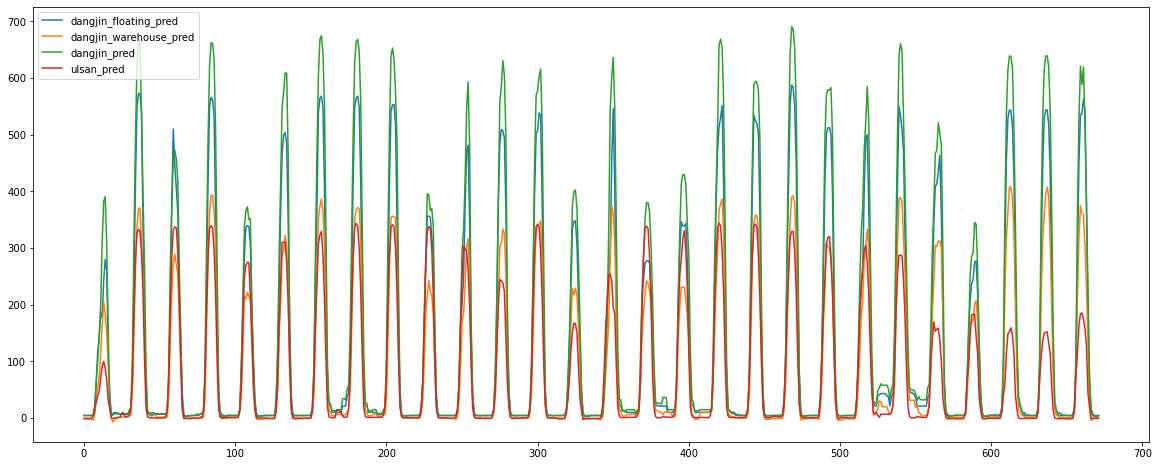

In [727]:
plt.figure(figsize=(20,8))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [728]:
sample_submission.iloc[:24*28, 1] = dangjin_floating_pred
sample_submission.iloc[:24*28, 2] = dangjin_warehouse_pred
sample_submission.iloc[:24*28, 3] = dangjin_pred
sample_submission.iloc[:24*28, 4] = ulsan_pred

In [731]:
sample_submission.to_csv('submission/donghwan6.csv', index=False)